#### First we start by importing all relevant libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from numpy.random import rand
from IPython.display import display
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif, SelectKBest
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.validation import column_or_1d
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

random_state = 42
import warnings

# Suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#Normally we have to import the dataset
data_url = 'Datasets/Ovarian_cancer.csv'
data = pd.read_csv(data_url)
#data.head(4)

In [3]:
data.shape #just to check the number of instances and features/variables our dataset have

(253, 15155)

In [4]:
#data.isnull().sum() #We check to see if our datasets has any missing values

In [5]:
#lets check the counts of the class types in our datasets
print("We have two classes: ", data['Class'].unique())
data.value_counts('Class')
# This tells us we have 162 instances of type cancer and 91 of type nirmal. Thus we need to do data imbalance handling

We have two classes:  ['Normal' 'Cancer']


Class
Cancer    162
Normal     91
dtype: int64

### We perform label encoding i.e, the target variable change from categorical to numeric

In [6]:
#machine learning algorithms cannot work with categoricla values, thus he has to label out target to numeric values
label_encoder = LabelEncoder()
data['Class'] = label_encoder.fit_transform(data['Class'])
data.Class.unique()

array([1, 0])

In [7]:
data.Class.value_counts() #We see that the cancer class [0] is the majority class with 162 counts of samoples

0    162
1     91
Name: Class, dtype: int64

In [8]:
data2 = data.copy()#we make a copy of our data for future references

In [9]:
# Display summary statistics to check the range of values so as to know if you need scaling
#summary_stats = data.describe()
#print(summary_stats)

# Check the minimum and maximum values for each feature
min_values = data.min()
if min_values.nunique() == 0.0:
    print("All elements have the same min value.")
else:
    print("Not all elements have the same min value.")

max_values = data.max()
if max_values.nunique() == 1.0:
    print("All elements have the same max value.")
else:
    print("Not all elements have the same max value.")
#from the output we need to perform a minmax scaling to make sure all our values are withing -1 and 1

Not all elements have the same min value.
All elements have the same max value.


In [10]:
#Now we split our dataframe into features and target
features = data.drop(['Class'], axis = 1) #dropping the target column
target = data.loc[:,['Class']] #picking only the target column
#features.head(3)

In [11]:
'''#Now let us handle the imbalancenature of our dataset using ROS
#we first haave to separate the two classes
majority_class_cancer = data[data['Class'] == 0]
minority_class_normal = data[data['Class'] == 1]

print("confirming to ensure its 162 samples in the majority class cancer: ",len(majority_class_cancer.Class))
print("confirming to ensure its 91 samples in the minority class cancer: ",len(minority_class_normal.Class))''';

In [12]:
'''# Upsample minority class to equal majority class
minority_upsample = resample(minority_class_normal, replace = True, n_samples = len(majority_class_cancer), random_state = random_state)
# Combine majority class with upsampled minority class
data_combined = pd.concat([majority_class_cancer, minority_upsample])
print("Checking the shape of our data once more: \n", data_combined.Class.value_counts())''';

### Now we use our SMOTE technique

In [13]:
#Now lets use the SMOTE technique to handle the imbalance data issues
smote = SMOTE(random_state = random_state, k_neighbors=5)
features, target = smote.fit_resample(features, target)

In [14]:
#Checking to see if SMOTE works
target.value_counts() # These shows that the classes a rebalanced now ie., 162 both

Class
0        162
1        162
dtype: int64

### Now we scale our data to be on same scale and avoid bais

In [15]:
min_max_scaler = MinMaxScaler(feature_range = (0,1))
data_scaled = min_max_scaler.fit_transform(features)
data_scaled = pd.DataFrame(data_scaled, columns = features.columns)
#data_scaled.head(2)

### We perform filter methods of gene selection

In [16]:
#SELECTION WITH CHI-SQUARE TEST
data_chi = SelectKBest(score_func = chi2)
data_chi.fit(data_scaled, target)

Table_score = pd.DataFrame(data_chi.scores_)
Table_names = pd.DataFrame(data2.columns)
chi_table = pd.concat([Table_names, Table_score], axis = 1)
chi_table.columns = ['Feature_Names', 'Scores']
chi_table.sort_values(by = 'Scores', ascending = False, inplace = True)
#display(chi_table)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [17]:
#SELECTION WITH MUTUAL INFORMATION
data_mi = SelectKBest(score_func = mutual_info_classif)
target_mi = target.copy()
#target_mi = target.ravel()

target_mi = column_or_1d(target_mi)

data_mi.fit(data_scaled, target_mi)

Table_score = pd.DataFrame(data_mi.scores_)
Table_names = pd.DataFrame(data2.columns)
mi_table = pd.concat([Table_names, Table_score], axis = 1)
mi_table.columns = ['Feature_Names', 'Scores']
mi_table.sort_values(by = 'Scores', ascending = False, inplace = True)
#display(mi_table)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [18]:
'''Now from our methodology, we aim to use 100, 200, 300, 400, and 500 features where the KNN will
automnatically select the feature subset with lesser error before paissing to the SSA'''
#we will roughly select 1000 top features from each of the filter methods
Top_1000_chi = chi_table.head(1000)
Top_1000_mi = mi_table.head(1000)

#Now we merge the two top 1000 features from each filter method to remove duplicates. The scoring is again done automatically.
merged_table = pd.concat([Top_1000_chi, Top_1000_mi], axis = 0)
merged_table.shape
#display(merged_table)

(2000, 2)

In [19]:
#we again ensure the features are ranked based on scores
merged_table.sort_values(by = 'Scores', ascending = False, inplace = True)
#display(merged_table)

In [20]:
# Check if any rows have the same value in the specified column
duplicate_values = merged_table.duplicated(subset=['Feature_Names'], keep=False)
# Filter the DataFrame to show only the rows with duplicate values
rows_with_duplicates = merged_table[duplicate_values]
#print(rows_with_duplicates)

In [21]:
#We realised that there are duplicates of features in the dataframe, thus we wil drop the one with a lower rank
# Drop duplicates based on the specified column, keeping the first occurrence
drop_duplicate = merged_table.drop_duplicates(subset = ['Feature_Names'], keep = 'first')
'''This will drop one of the rows that came lower in the DataFrame based on the specified
column name and keep only the first occurrence of the duplicate values''';
drop_duplicate.shape

(1300, 2)

### Our proposed method of determining and selection optimal gene subset based on minimal error

In [22]:
#Manipulate as much as yuh can, both 'n' and size of each n = 1

#Activate this set for n = 5 with (100,200,300,400,500)
#Now we select top 100 
'''Top_100 = drop_duplicate.head(100)
Top_100_features = Top_100['Feature_Names'].tolist()
Top_100_data = data2.loc[:,Top_100_features]

#Now we select top 200 
Top_200 = drop_duplicate.head(200)
Top_200_features = Top_200['Feature_Names'].tolist()
Top_200_data = data2.loc[:,Top_200_features]

#Now we select top 300 
Top_300 = drop_duplicate.head(300)
Top_300_features = Top_300['Feature_Names'].tolist()
Top_300_data = data2.loc[:,Top_300_features]

#Now we select top 400 
Top_400 = drop_duplicate.head(400)
Top_400_features = Top_400['Feature_Names'].tolist()
Top_400_data = data2.loc[:,Top_400_features]

#Now we select top 500 
Top_500 = drop_duplicate.head(500)
Top_500_features = Top_500['Feature_Names'].tolist()
Top_500_data = data2.loc[:,Top_500_features]''';



'''#Now we select top n 
Top_n = drop_duplicate.head(n)
Top_n_features = Top_n['Feature_Names'].tolist()
Top_n_data = data2.loc[:,Top_n_features]''';



#Activate this set for n = 10 with (50,100,150,200,250,300,350,400,450,500)
#Now we select top 50 
Top_50 = drop_duplicate.head(5)
Top_50_features = Top_50['Feature_Names'].tolist()
Top_50_data = data2.loc[:,Top_50_features]

#Now we select top 100 
Top_100 = drop_duplicate.head(10)
Top_100_features = Top_100['Feature_Names'].tolist()
Top_100_data = data2.loc[:,Top_100_features]

#Now we select top 150 
Top_150 = drop_duplicate.head(15)
Top_150_features = Top_150['Feature_Names'].tolist()
Top_150_data = data2.loc[:,Top_150_features]

#Now we select top 200 
Top_200 = drop_duplicate.head(20)
Top_200_features = Top_200['Feature_Names'].tolist()
Top_200_data = data2.loc[:,Top_200_features]

#Now we select top 250 
Top_250 = drop_duplicate.head(25)
Top_250_features = Top_250['Feature_Names'].tolist()
Top_250_data = data2.loc[:,Top_250_features]

#Now we select top 300 
Top_300 = drop_duplicate.head(30)
Top_300_features = Top_300['Feature_Names'].tolist()
Top_300_data = data2.loc[:,Top_300_features]

#Now we select top 350 
Top_350 = drop_duplicate.head(35)
Top_350_features = Top_350['Feature_Names'].tolist()
Top_350_data = data2.loc[:,Top_350_features]

#Now we select top 400 
Top_400 = drop_duplicate.head(40)
Top_400_features = Top_400['Feature_Names'].tolist()
Top_400_data = data2.loc[:,Top_400_features]

#Now we select top 450 
Top_450 = drop_duplicate.head(45)
Top_450_features = Top_450['Feature_Names'].tolist()
Top_450_data = data2.loc[:,Top_450_features]

#Now we select top 500 
Top_500 = drop_duplicate.head(50)
Top_500_features = Top_500['Feature_Names'].tolist()
Top_500_data = data2.loc[:,Top_500_features]

In [23]:
Top_100_data.shape[1] #sample to look at how it is

10

In [24]:
target = np.ravel(target) #converting our target variable into a numpy array
#target = target.values

In [25]:
#Activate for n = 10
data_sizes = [Top_50_data.values, Top_100_data.values, Top_150_data.values,Top_200_data.values,Top_250_data.values,Top_300_data.values, Top_350_data.values, Top_400_data.values,Top_450_data.values,Top_500_data.values]
#Activate for n = 5
#data_sizes = [Top_100_data.values,Top_200_data.values,Top_300_data.values,Top_400_data.values,Top_500_data.values] 
best_size = []

for data_size in data_sizes:
    kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
    
    for train_index, test_index in kf.split(data_size):
        X_train, X_test = data_size[train_index], data_size[test_index]
        y_train, y_test = target[train_index], target[test_index]

        selection_model = KNeighborsClassifier(n_neighbors = 5)
        selection_model.fit(X_train, y_train)
        y_pred = selection_model.predict(X_test)
        error_rate = 1 - (accuracy_score(y_test, y_pred))
        
    best_size.append(round(error_rate,2))
    #print(f'The error rate of {data_size.shape[1]} top features is: {round(error_rate,2)}, while the accuracy id {1- (round(error_rate,2))}%')
    #print('\n')
print("Error rates of the splits", best_size)

#we auotmatically select the best subset size based on the error rate value and use it in our SSA
error_index = best_size.index(min(best_size)) #find the min value in best_size ie.,min error rate = best acccuracy
selected_Top_data = data_sizes[error_index] # Access the corresponding element in data_sizes using the index of min value of best_size

print('Index of best split: ', error_index) #printing for debugging
print('Shape of selected split: ', selected_Top_data.shape) #printing for debugging



kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
#Because we are using the same value of k and random state, we will always get same train-test split and hence, same result

for train_index, test_index in kf.split(selected_Top_data):
    x_train, x_test = selected_Top_data[train_index], selected_Top_data[test_index]
    y_train, y_test = target[train_index], target[test_index]

fold = {'xt': x_train, 'yt': y_train, 'xv': x_test, 'yv': y_test} #Requirement for our SSA algorithm
#We print out to see the number of instances in each of the classes
print(f'Training set:{x_train.shape}')
print(f'Testing set:{x_test.shape}')
print(f'Training_Label set:{y_train.shape}')
print(f'Testing_Lable set:{y_test.shape}')

Error rates of the 5 splits [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]
Index of best split:  0
Shape of selected split:  (253, 5)
Training set:(228, 5)
Testing set:(25, 5)
Training_Label set:(228,)
Testing_Lable set:(25,)


### We start defining our SSA funtions from here

In [26]:
#Instead of using the random initialization, we use the chaotic map initialization (sinusoidal map)
def sinusoidal_map(P, x0, n):

    # Initialize an array to store the generated values
    values = np.zeros(n)
    # Set the initial value
    x = x0
    # Generate values using the sinusoidal map equation
    #By default, all values are within [0-1]
    for i in range(n):
        x = P * (x ** 2) * np.sin(np.pi * x)
        values[i] = x
    
    return values

In [27]:
'''P = 2.3
x0 = .7
n = 10
gen_vals = sinusoidal_map(P, x0, n)
assigned_val = np.random.choice(gen_vals)
assigned_val '''; #Just testing the workings of the sinusoidal map

In [28]:
#Chaotic map (Sinusoidal) population initailization as opposed to random
def init_position(lb, ub, N, dim, P, x0):
    X = np.zeros([N, dim], dtype='float')
    
    chaotic_values = sinusoidal_map(P, x0, N * dim)
    # Assign the chaotic values to the positions within bounds
    index = 0
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * chaotic_values[index]
            index +=1
            #X[i,d] = lb[d] + (ub[d] - lb[d]) * np.random.rand()
            
    return X

In [29]:
def sigmoid(x):

    return 1 / (1 + np.exp(-x))

def binary_conversion(X, thres, N, dim):

    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if sigmoid(X[i, d]) > thres:
                Xbin[i, d] = 1
            else:
                Xbin[i, d] = 0
    return Xbin

In [30]:
#making our search space to remian between 0 and 1
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
        
    return x

In [31]:
#Error rate/accuracy
def error_rate(xtrain, ytrain, x, opts):
    #parameters
    k = opts['k']
    
    fold = opts['fold']
    xt = fold['xt']
    yt = fold['yt']
    xv = fold['xv']
    yv = fold['yv']
    
    #Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    #Define selected features
    xtrain = xt[:, x == 1]
    ytrain = yt.reshape(num_train)
    xvalid = xv[:, x == 1]
    yvalid = yv.reshape(num_valid)
    
    #training our KNN model
    mdl = KNeighborsClassifier(n_neighbors=k)
    mdl.fit(xtrain, ytrain)
    
    #making predictions
    ypred = mdl.predict(xvalid)
    acc = accuracy_score(ypred, yvalid)
    #acc = np.sum(yvalid == ypred) / num_valid
    error = 1 - acc
    
    return error

In [32]:
#Error rate and Feature Size (Fitness Fucntion)
def Fun(xtrain, ytrain, x, opts):
    #parameters
    alpha = 0.99 #default value in literature
    beta = 1 - alpha #default value in literature
    
    #original feature size
    max_feat = len(x)
    #number of selected features
    num_feat = np.sum(x==1)
    #If no feature is selected smiles (impossible)
    if num_feat == 0:
        cost = 1 #Add your code if you like
    else:
        #get error rate fucntion
        error = error_rate(xtrain, ytrain, x, opts)
        #objective/fitness fucntion
        cost = alpha * error + beta * (num_feat/max_feat)
    
    return cost

In [33]:
def main_fs(xtrain, ytrain, opts):
    #our parameters
    ub = 1
    lb = 0
    thres = .5
    P = 2.3 #according to literature
    x0 = 0.7 #according to literature
    
    N = opts['N']
    max_iter = opts['T']
    
    #The dimension of our dataset
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype = 'float')
        lb = lb * np.ones([1, dim], dtype = 'float')
        
    #Initialize position of salps
    X = init_position(lb, ub, N, dim, P, x0) #Sinusoidal map
    
    fit = np.zeros([N, 1], dtype = 'float')
    Xf = np.zeros([1, dim], dtype = 'float')
    fitF = float('inf')
    curve = np.zeros([1, max_iter], dtype = 'float')
    t = 0
    
    while t < max_iter:
        #binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        #Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitF:
                Xf[0,:] = X[i,:]
                fitF = fit[i,0]
                
        #store results
        curve[0,t] = fitF.copy()
        print('Iteration: ', t + 1)
        print("Best (SSA): ", curve[0,t])
        t = t + 1
        
        #Compute coefficent, c1 from SSA algorithm
        c1 = 2 * np.exp(-(4 * t / max_iter)**2)
        
        for i in range(N):
            #First leader update
            if i == 0:
                for d in range(dim):
                    #coefficient of c2 and c3 in the range of 0 - 1 where random originally but we use chaotic map
                    
                    #c2 = np.random.choice(sinusoidal_map(P, x0, 10))
                    #c3 = np.random.choice(sinusoidal_map(P, x0, 10))
                    c2 = np.random.choice(sinusoidal_map(P, x0, 10))
                    c3 = np.random.rand()
                    #leader update
                    if c3>=.5: #from the literature
                        X[i,d] = Xf[0,d] + c1 * ((ub[0,d] -lb[0,d]) * c2 + lb[0,d])
                    else:
                        X[i,d] = Xf[0,d] - c1 * ((ub[0,d] - lb[0,d]) * c2 + lb[0,d])
                        
                    #boundary
                    X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                
            #salp update
            elif i >= 1:
                for d in range(dim):
                    #salp update by following leader salp
                    X[i,d] =(X[i,d] + X[i - 1, d]) / 2
                    #boundary
                    X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
                
    
    #Best feature subset
    Gbin = binary_conversion(Xf, thres, 1, dim)
    Gbin = Gbin.reshape(dim)
    pos  = np.asarray(range(0,dim))
    sel_index = pos[Gbin == 1]
    num_feat = len(sel_index)
    
    #create dictionary
    ssa_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return ssa_data

In [34]:
#Now you run our SSA algorithm
#Now we set the general parameters
K = 5 #K value in KNN
N = 30 #Population size/swarm size
T = 50 #Max iteration/generations
opts = {'k': K, 'fold': fold, 'N': N, 'T': T}

In [35]:
#Now we perform our feature selection by calling the main module
feature_selection_mdl = main_fs(selected_Top_data, target, opts) #feature selection model
sf = feature_selection_mdl['sf'] #index of selected features
#print(sf)

Iteration:  1
Best (SSA):  0.04960000000000005
Iteration:  2
Best (SSA):  0.04560000000000004
Iteration:  3
Best (SSA):  0.04560000000000004
Iteration:  4
Best (SSA):  0.04560000000000004
Iteration:  5
Best (SSA):  0.04360000000000004
Iteration:  6
Best (SSA):  0.04160000000000004
Iteration:  7
Best (SSA):  0.04160000000000004
Iteration:  8
Best (SSA):  0.04160000000000004
Iteration:  9
Best (SSA):  0.04160000000000004
Iteration:  10
Best (SSA):  0.04160000000000004
Iteration:  11
Best (SSA):  0.04160000000000004
Iteration:  12
Best (SSA):  0.04160000000000004
Iteration:  13
Best (SSA):  0.04160000000000004
Iteration:  14
Best (SSA):  0.04160000000000004
Iteration:  15
Best (SSA):  0.04160000000000004
Iteration:  16
Best (SSA):  0.04160000000000004
Iteration:  17
Best (SSA):  0.04160000000000004
Iteration:  18
Best (SSA):  0.04160000000000004
Iteration:  19
Best (SSA):  0.04160000000000004
Iteration:  20
Best (SSA):  0.04160000000000004
Iteration:  21
Best (SSA):  0.04160000000000004
I

In [36]:
#Model with selected features
num_train = np.size(x_train,0)#checks the number of samples slected in the x_train and assign to num_train
num_test = np.size(x_test, 0)#checks the number of samples slected in the x_train and assign to num_train
xtrain = x_train[:,sf]
ytrain = y_train.reshape(num_train)
xtest = x_test[:,sf]
ytest = y_test.reshape(num_test)

In [37]:
#Now we build our model i.e., the classifier
KNN_model = KNeighborsClassifier(n_neighbors = 5)
KNN_model.fit(xtrain, ytrain)  

KNeighborsClassifier()

In [38]:
#Method to calculate accuracy for our unseen data
def train_test_accuracy(model, xtest, ytest, name = ''):
    y_pred = model.predict(xtest)
    test_accuracy = round(accuracy_score(y_pred, ytest)*100, 2)
    test_F1_measure = round(f1_score(y_pred, ytest)*100,2)
    error = 1 - round(accuracy_score(y_pred, ytest), 3)
        
    return print("The ACCURACY SCORE is: {} \nThe F1_MEASURE is {} \nThe error rate is: {}". format(test_accuracy, test_F1_measure, error))

In [39]:
#Calling our fucntion to display result
train_test_accuracy(KNN_model, xtest, ytest, name = 'SSA')

The ACCURACY SCORE is: 96.0 
The F1_MEASURE is 92.31 
The error rate is: 0.040000000000000036


In [40]:
#Now we check the number of selected features
Number_of_features = len(sf)
print(f'The number of FEATURES selected is: {Number_of_features}')

The number of FEATURES selected is: 1


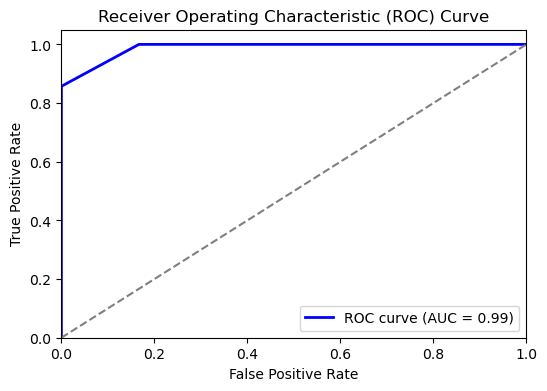

In [41]:
# Predict probabilities on the test set
y_probabilities = KNN_model.predict_proba(xtest)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(ytest, y_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### End of project